In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import copy

%matplotlib inline

from plotting import plot_utils, summary_plots, load_fits, plot_prf_params
plot_utils.set_all_font_sizes(16)
from utils import roi_utils, default_paths, stats_utils

In [4]:
# Load results of the fitting procedure

subject = 1
volume_space=True
feature_type_list_long = ['semantic_discrim_raw_val', 'gabor_solo_ridge_12ori_8sf',\
                 'texture_pyramid_ridge_4ori_4sf_pca_HL','sketch_tokens',\
                 'alexnet_best_layer_pca', 'clip_RN50_best_layer_pca']
feature_type_list = ['raw','gabor',\
                 'texture_pyramid','sketch_tokens',\
                 'alexnet', 'clip']
nf = [0,0,0,0,0,0,0]

for fi, fitting_type in enumerate(feature_type_list_long):
    out= load_fits.load_fit_results(subject, fitting_type,n_from_end=nf[fi],verbose=True);

    if fi==0:
        n_voxels = out['sem_corr_each_axis'].shape[0]
        n_discrim_types = out['sem_discrim_each_axis'].shape[1]
        sem_corr = np.zeros((len(feature_type_list), n_discrim_types, n_voxels))
        sem_discrim = np.zeros((len(feature_type_list), n_discrim_types, n_voxels))
        clip_r2 = np.zeros((n_voxels,))
        discrim_type_list = out['discrim_type_list']
        
    sem_corr[fi,:,:] = out['sem_corr_each_axis'].T
    sem_discrim[fi,:,:] = out['sem_discrim_each_axis'].T
    
    if 'clip' in fitting_type:
        clip_r2 = out['val_r2'][:,0]

np.all(np.isnan(sem_discrim)==np.isnan(sem_corr))
sem_discrim[np.isinf(sem_discrim)] = np.nan

which_prf_grid=5
top_two_fn = os.path.join(default_paths.stim_labels_root, \
                           'Coco_supcat_top_two_prf_grid%d.npy'%(which_prf_grid))
top_two = np.load(top_two_fn, allow_pickle=True).item()
top_two['things_top_two']['animal']

roi_def = roi_utils.nsd_roi_def(subject, verbose=False)

loading from /user_data/mmhender/imStat/model_fits/S01/semantic_discrim_raw_val/Feb-08-2022_2326_41/all_fit_params.npy

dict_keys(['subject', 'volume_space', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'which_prf_grid', 'models', 'debug', 'up_to_sess', 'single_sess', 'best_model_each_voxel', 'saved_prfs_fn', 'sem_discrim_each_axis', 'sem_corr_each_axis', 'discrim_type_list'])
loading from /user_data/mmhender/imStat/model_fits/S01/gabor_solo_ridge_12ori_8sf/Feb-05-2022_2056_56/all_fit_params.npy

dict_keys(['subject', 'volume_space', 'fitting_types', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'which_prf_grid', 'models', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'ridge', 'debug', 'up_to_sess', 'single_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'saved_prfs_fn', 'best_layer_each_voxel', 'saved_be

In [16]:
np.nanmin(np.nanmin(sem_discrim[:,0:3,:], axis=1), axis=1)

array([-32.48923471, -35.65190073, -36.4708989 , -41.43941504,
       -49.76917223, -76.48567166])

In [5]:
roi_names =roi_def.roi_names
# areas2plot = np.array([0,1,2,3,6,13,14,17,18,20,21])
skip_inds = [4,5,7,10,11,15,16,23]
areas2plot = np.arange(len(roi_names))
areas2plot = areas2plot[~np.isin(areas2plot, skip_inds)]
print(np.array(roi_names)[areas2plot])
print(np.array(roi_names)[~np.isin(np.arange(len(roi_names)), areas2plot)])
n_rois_plot = len(areas2plot)

['V1' 'V2' 'V3' 'hV4' 'LO1-2' 'V3ab' 'IPS0-5' 'OFA' 'FFA-1' 'FFA-2' 'OPA'
 'PPA' 'RSC' 'EBA' 'FBA-1' 'FBA-2']
['VO1-2' 'PHC1-2' 'TO1-2' 'SPL1' 'FEF' 'mTL-faces' 'aTL-faces'
 'mTL-bodies']


In [6]:
has_missing = np.any(np.sum(np.isnan(sem_discrim), axis=2)>0, axis=0)
print(np.array(discrim_type_list)[has_missing])
print(np.array(discrim_type_list)[~has_missing])

['sports' 'within_accessory' 'within_animal' 'within_appliance'
 'within_electronic' 'within_food' 'within_indoor' 'within_kitchen'
 'within_outdoor' 'within_sports' 'within_vehicle' 'ceiling' 'other'
 'window' 'within_building' 'within_floor' 'within_food-stuff'
 'within_furniture-stuff' 'within_solid' 'within_structural'
 'within_textile' 'within_water']
['indoor_outdoor' 'natural_humanmade' 'animacy' 'accessory' 'animal'
 'appliance' 'electronic' 'food' 'furniture' 'indoor' 'kitchen' 'outdoor'
 'person' 'vehicle' 'within_furniture' 'building' 'floor' 'food-stuff'
 'furniture-stuff' 'ground' 'plant' 'raw-material' 'sky' 'solid'
 'structural' 'textile' 'wall' 'water' 'within_ground' 'within_plant'
 'within_raw-material' 'within_wall']


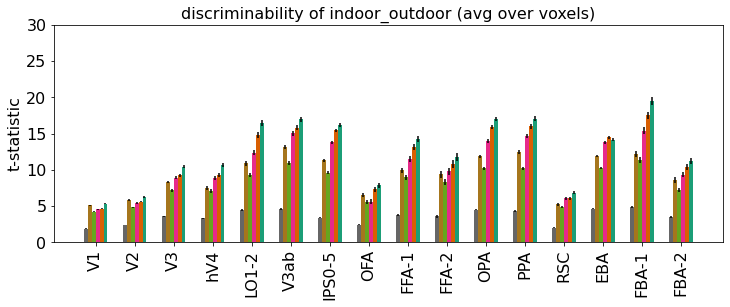

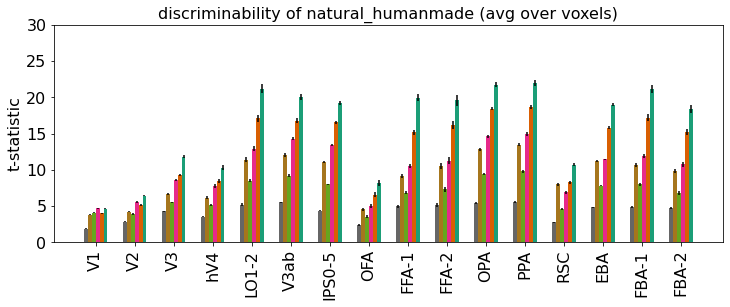

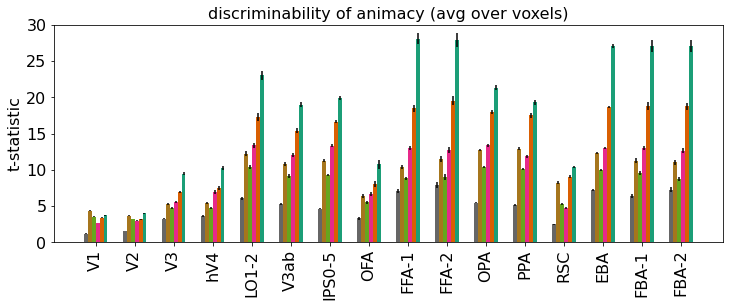

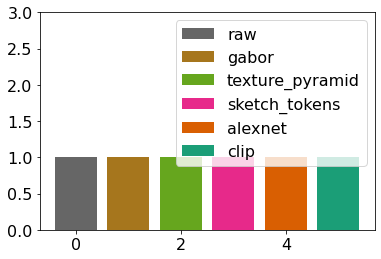

In [8]:

feature_colors = np.flipud(cm.Dark2(np.linspace(0,1,len(feature_type_list))))
bar_jitters = np.linspace(-0.25, 0.25,len(feature_type_list))
bar_width = np.diff(bar_jitters[0:2])[0]
    
# dd2plot = np.where([~has_missing])[1]
dd2plot = [0,1,2]

vox2use = clip_r2>0.01

for dd in dd2plot:
    
    discrim_type = discrim_type_list[dd]
    
    mean_val_each_roi = np.zeros((len(feature_type_list), len(areas2plot)))
    std_val_each_roi = np.zeros((len(feature_type_list), len(areas2plot)))
    n_each_roi = np.zeros((len(areas2plot),))
    
    for fi in range(len(feature_type_list)):
        for ri, rr in enumerate(areas2plot):
            inds_this_roi = roi_def.get_indices(rr)
            inds_this_roi = inds_this_roi & vox2use
            
            vals = np.abs(sem_discrim[fi,dd,inds_this_roi])
            
            if len(vals)==0:
                print('no voxels in %s'%roi_names[rr])
                continue
                
            n_each_roi[ri] = len(vals)
            mean_val_each_roi[fi,ri] = np.mean(vals)
            std_val_each_roi[fi,ri] = np.std(vals)
   
    plt.figure(figsize=(12,4));
    
    for fi in range(len(feature_type_list)):
        plt.bar(np.arange(n_rois_plot)+bar_jitters[fi],mean_val_each_roi[fi,:],\
                width=bar_width, color=feature_colors[fi,:])
        plt.errorbar(np.arange(n_rois_plot)+bar_jitters[fi],mean_val_each_roi[fi,:],\
                     std_val_each_roi[fi,:]/np.sqrt(n_each_roi), ecolor='k', \
                    ls='none',zorder=10)
    plt.xticks(np.arange(n_rois_plot), labels=np.array(roi_names)[areas2plot], rotation=90);
    plt.ylabel('t-statistic')
    plt.title('discriminability of %s (avg over voxels)'%discrim_type)
    plt.ylim([0,30])

plt.figure();
for fi in range(len(feature_type_list)):
    plt.bar([fi],[1],color=feature_colors[fi,:])
plt.ylim([0,3])
plt.legend(feature_type_list)

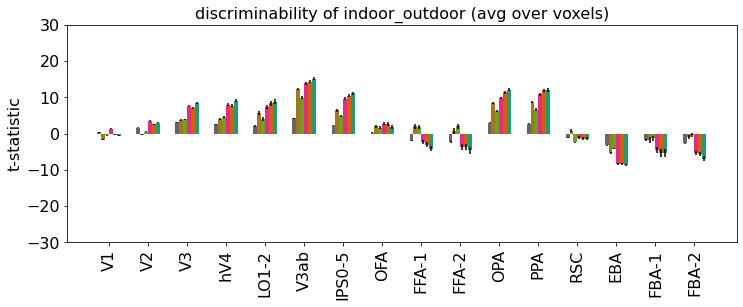

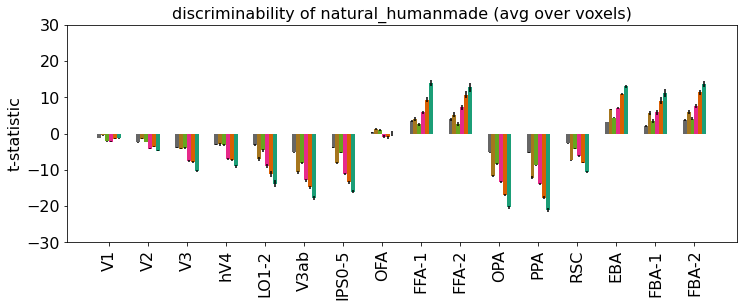

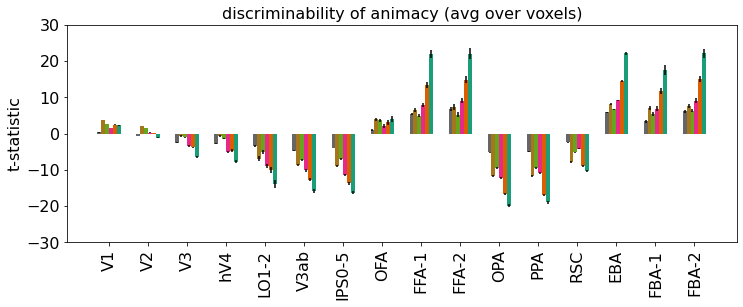

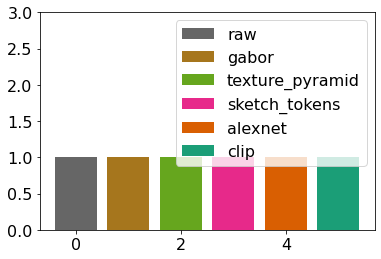

In [11]:

feature_colors = np.flipud(cm.Dark2(np.linspace(0,1,len(feature_type_list))))
bar_jitters = np.linspace(-0.25, 0.25,len(feature_type_list))
bar_width = np.diff(bar_jitters[0:2])[0]
    
# dd2plot = np.where([~has_missing])[1]
dd2plot = [0,1,2]

vox2use = clip_r2>0.01

for dd in dd2plot:
    
    discrim_type = discrim_type_list[dd]
    
    mean_val_each_roi = np.zeros((len(feature_type_list), len(areas2plot)))
    std_val_each_roi = np.zeros((len(feature_type_list), len(areas2plot)))
    n_each_roi = np.zeros((len(areas2plot),))
    
    for fi in range(len(feature_type_list)):
        for ri, rr in enumerate(areas2plot):
            inds_this_roi = roi_def.get_indices(rr)
            inds_this_roi = inds_this_roi & vox2use
            
            vals = (-1)*sem_discrim[fi,dd,inds_this_roi]
            
            if len(vals)==0:
                print('no voxels in %s'%roi_names[rr])
                continue
                
            n_each_roi[ri] = len(vals)
            mean_val_each_roi[fi,ri] = np.mean(vals)
            std_val_each_roi[fi,ri] = np.std(vals)
   
    plt.figure(figsize=(12,4));
    
    for fi in range(len(feature_type_list)):
        plt.bar(np.arange(n_rois_plot)+bar_jitters[fi],mean_val_each_roi[fi,:],\
                width=bar_width, color=feature_colors[fi,:])
        plt.errorbar(np.arange(n_rois_plot)+bar_jitters[fi],mean_val_each_roi[fi,:],\
                     std_val_each_roi[fi,:]/np.sqrt(n_each_roi), ecolor='k', \
                    ls='none',zorder=10)
    plt.xticks(np.arange(n_rois_plot), labels=np.array(roi_names)[areas2plot], rotation=90);
    plt.ylabel('t-statistic')
    plt.title('discriminability of %s (avg over voxels)'%discrim_type)
    plt.ylim([-30,30])

plt.figure();
for fi in range(len(feature_type_list)):
    plt.bar([fi],[1],color=feature_colors[fi,:])
plt.ylim([0,3])
plt.legend(feature_type_list)